c:\Users\angel\.conda\envs\pytorch\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


entering find best hyperparameters
Best hyperparameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 150}

Validation Set Performance:
Confusion Matrix:
[[174   0   7   0   0   1   3]
 [  0  67   0   0   0   0   0]
 [ 13   0 200   0   3   0   1]
 [ 13   0   0 496   0   3  21]
 [  5   0   3   1 259   0   6]
 [  6   0   1   7   1 240   7]
 [ 15   0   0  48   2   5 298]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85       185
           1       1.00      1.00      1.00        67
           2       0.95      0.92      0.93       217
           3       0.90      0.93      0.91       533
           4       0.98      0.95      0.96       274
           5       0.96      0.92      0.94       262
           6       0.89      0.81      0.85       368

    accuracy                           0.91      1906
   macro avg       0.92      0.92      0.92      1906
weighted avg       

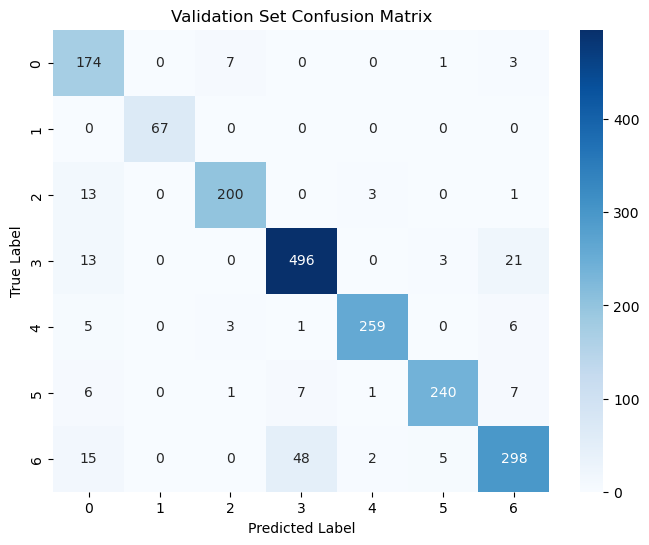


Final Model Performance on Training Data (train+validation):
Confusion Matrix:
[[ 910    0    9    0    0    0    6]
 [   0  365    0    0    0    0    0]
 [  22    0 1117    0    1    0    1]
 [  55    0    0 2367    0    7   53]
 [  13    0    7    7 1312    0   11]
 [  21    0    1    9    0 1378   10]
 [  77    0    2  122    7    8 1629]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       925
           1       1.00      1.00      1.00       365
           2       0.98      0.98      0.98      1141
           3       0.94      0.95      0.95      2482
           4       0.99      0.97      0.98      1350
           5       0.99      0.97      0.98      1419
           6       0.95      0.88      0.92      1845

    accuracy                           0.95      9527
   macro avg       0.96      0.96      0.96      9527
weighted avg       0.96      0.95      0.95      9527

F1 Score (weighted): 0.953191936

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Read dataset (adjust the path if needed)
df = pd.read_csv("Dry_Bean_Dataset.csv")
# print("Dataset head:")
# print(df.head())

# Separate features and target (assuming the target column is named 'Class')
X = df.drop("Class", axis=1)
y = df["Class"]

# One-hot encode the target variable
ohe = OneHotEncoder(sparse=False)
y_encoded = ohe.fit_transform(y.values.reshape(-1, 1))

# Split the data into training, validation, and test sets
# First, split off the test set (e.g., 30% test)
X_train_val, X_test, y_train_val_enc, y_test_enc = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y
)

# Now, split the remaining data into training and validation sets (e.g., 80% train, 20% val)
X_train, X_val, y_train_enc, y_val_enc = train_test_split(
    X_train_val, y_train_val_enc, test_size=0.2, random_state=42
)

# Set up a MultiOutputClassifier with a GradientBoostingClassifier.
# We will tune hyperparameters of the underlying estimator.
base_clf = GradientBoostingClassifier(random_state=42)
model = MultiOutputClassifier(base_clf)

# Define the hyperparameter grid.
# Note: Use the prefix "estimator__" to specify parameters for the underlying estimator.
param_grid = {
    "estimator__n_estimators": [50, 100, 150],
    "estimator__learning_rate": [0.01, 0.1, 0.2],
    "estimator__max_depth": [3, 4, 5]
}
print("entering find best hyperparameters")
# Tune hyperparameters by performing GridSearchCV on the training set
grid = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, refit=True)
grid.fit(X_train, y_train_enc)
print("Best hyperparameters:", grid.best_params_)

# Evaluate the best model on the validation set. (because the result comes from the average results of multiple splits, there may be bias, need to see a specific result on the validation set)
y_val_pred_enc = grid.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred_enc, axis=1)
y_val_labels = np.argmax(y_val_enc, axis=1)

print("\nValidation Set Performance:")
print("Confusion Matrix:")
print(confusion_matrix(y_val_labels, y_val_pred_labels))
print("\nClassification Report:")
print(classification_report(y_val_labels, y_val_pred_labels))
print("F1 Score (weighted):", f1_score(y_val_labels, y_val_pred_labels, average='weighted'))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_val_labels, y_val_pred_labels), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Set Confusion Matrix")
plt.show()
# Retrain the model on the entire training set using the best hyperparameters.
X_train_final = X_train_val    # training+validation
y_train_final_enc = y_train_val_enc

final_base = GradientBoostingClassifier(
    random_state=42,
    n_estimators=grid.best_params_["estimator__n_estimators"],
    learning_rate=grid.best_params_["estimator__learning_rate"],
    max_depth=grid.best_params_["estimator__max_depth"]
)
final_model = MultiOutputClassifier(final_base)
final_model.fit(X_train_final, y_train_final_enc)

# Evaluate the final model on:
# 1. Training data (train+validation)
y_train_final_pred_enc = final_model.predict(X_train_final)
y_train_final_pred_labels = np.argmax(y_train_final_pred_enc, axis=1)
y_train_final_labels = np.argmax(y_train_final_enc, axis=1)

print("\nFinal Model Performance on Training Data (train+validation):")
print("Confusion Matrix:")
print(confusion_matrix(y_train_final_labels, y_train_final_pred_labels))
print("\nClassification Report:")
print(classification_report(y_train_final_labels, y_train_final_pred_labels))
print("F1 Score (weighted):", f1_score(y_train_final_labels, y_train_final_pred_labels, average='weighted'))

# 2. Test data
y_test_pred_enc = final_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred_enc, axis=1)
y_test_labels = np.argmax(y_test_enc, axis=1)

print("\nFinal Model Performance on Test Data:")
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_test_pred_labels))
print("\nClassification Report:")
print(classification_report(y_test_labels, y_test_pred_labels))
print("F1 Score (weighted):", f1_score(y_test_labels, y_test_pred_labels, average='weighted'))

# 3. Whole dataset (training+validation+test)
y_all_enc = y_encoded
y_all_labels = np.argmax(y_all_enc, axis=1)
y_all_pred_enc = final_model.predict(X)
y_all_pred_labels = np.argmax(y_all_pred_enc, axis=1)

print("\nFinal Model Performance on the Whole Dataset:")
print("Confusion Matrix:")
print(confusion_matrix(y_all_labels, y_all_pred_labels))
print("\nClassification Report:")
print(classification_report(y_all_labels, y_all_pred_labels))
print("F1 Score (weighted):", f1_score(y_all_labels, y_all_pred_labels, average='weighted'))



Additional Test Set Metrics:
Accuracy: 91.14%
Precision: 0.92
Recall: 0.93
F1 Score: 0.92


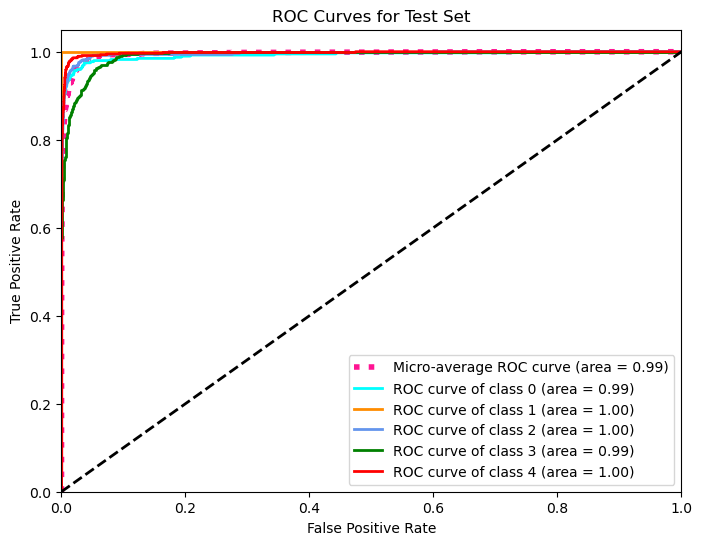

Overall ROC AUC (macro-average): 0.99


In [5]:
# Import additional evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score

# Evaluate additional metrics on Test Data
# Get predicted labels for test set
y_test_pred = final_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(y_test_enc, axis=1)

# Calculate metrics
test_accuracy = accuracy_score(y_test_true, y_test_pred_labels)
test_precision = precision_score(y_test_true, y_test_pred_labels, average='macro')
test_recall = recall_score(y_test_true, y_test_pred_labels, average='macro')
test_f1 = f1_score(y_test_true, y_test_pred_labels, average='macro')

print("\nAdditional Test Set Metrics:")
print("Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Precision: {:.2f}".format(test_precision))
print("Recall: {:.2f}".format(test_recall))
print("F1 Score: {:.2f}".format(test_f1))

# Compute predicted probabilities for ROC curves.
# For a MultiOutputClassifier with one-hot encoded targets, each estimator returns probability arrays.
# We extract the probability for the positive class (i.e., column index 1) for each output.
probas_list = final_model.predict_proba(X_test)
# Each element in probas_list is an array of shape (n_samples, 2); we take the probability for class "1".
# Then, stack them horizontally to build an (n_samples, n_classes) array.
y_pred_proba = np.hstack([proba[:, 1].reshape(-1, 1) for proba in probas_list])

# Compute ROC curve and AUC for each class.
n_classes = y_test_enc.shape[1]
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_enc[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_enc.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and the micro-average.
plt.figure(figsize=(8,6))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']  # Adjust if number of classes > 5
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Test Set')
plt.legend(loc="lower right")
plt.show()

# Compute overall (macro-average) ROC AUC score:
overall_auc = roc_auc_score(y_test_enc, y_pred_proba, multi_class="ovr", average="macro")
print("Overall ROC AUC (macro-average): {:.2f}".format(overall_auc))